In [1]:
%matplotlib inline

import os
import os.path
import glob
import random
import copy
import math
import scipy.io
import pickle

import shutil
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data_utils

from __future__ import print_function
from time import time, sleep
from scipy import misc
from sklearn.neighbors import NearestNeighbors

from skimage.io import imread
from skimage.io import imshow
from skimage.io import imsave
from skimage.transform import rescale

from torchvision import transforms
from torchvision.models import vgg19
from torchvision.models.vgg import model_urls
from torch.utils.serialization import load_lua
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim import LBFGS

from IPython import display
from IPython.display import clear_output
from PIL import Image

In [2]:
print(os.environ['CUDA_VISIBLE_DEVICES'])

1


In [3]:
import network

In [4]:
import cv2

## Options

In [5]:
opt_s_image_file = '/media/hpc-4_Raid/dsungatullina/transfer-to-zhores/_lists_512/synthia_rgb_val.txt'
opt_s_depth_file = '/media/hpc-4_Raid/dsungatullina/transfer-to-zhores/_lists_512/synthia_depth_val.txt'

In [6]:
opt_r_image_file = '/media/hpc-4_Raid/dsungatullina/transfer-to-zhores/_lists_512/cityscapes_rgb_val.txt'
opt_r_depth_file = '/media/hpc-4_Raid/dsungatullina/transfer-to-zhores/_lists_512/cityscapes_depth_val.txt'

In [7]:
opt_batch_size = 16

## Prepare data

### Synthetic

In [8]:
#         self.parser.add_argument('--mean_depth_synt', type=float, default=0.091)
#         self.parser.add_argument('--std_depth_synt', type=float, default=0.246)
#         self.parser.add_argument('--mean_depth_real', type=float, default=0.06)
#         self.parser.add_argument('--std_depth_real', type=float, default=0.1)

In [9]:
img_transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# depth_transform = transforms.Compose([transforms.ToTensor(), 
#                                     transforms.Normalize([0.091], [0.246])])

In [10]:
opt_s_image_list = open(opt_s_image_file, 'r')
opt_s_depth_list = open(opt_s_depth_file, 'r')
s_filenames_img = []
s_filenames_dpt = []

for line in opt_s_image_list:
    s_filenames_img.append(line[:-1])
    
    image = Image.open(line[:-1]).convert('RGB')
    image = img_transform(image)
    
    depth_line = opt_s_depth_list.readline()
    s_filenames_dpt.append(depth_line[:-1])                       
                           
    depth = cv2.imread(depth_line[:-1], cv2.IMREAD_UNCHANGED)
    depth[depth > 473.57] = 473.57
#     depth = (depth / 473.57)*255.0
#     depth = Image.fromarray(depth.astype(np.uint8))
#     depth = depth.convert('L')
#     depth = depth_transform(depth)
    
opt_s_image_list.close()
opt_s_depth_list.close()

In [11]:
print(image.size())
print(image.min(), image.max())
print(depth.shape)
# print(depth.min(), depth.max())

torch.Size([3, 304, 512])
tensor(-1.) tensor(1.)
(304, 512)


In [12]:
print(len(s_filenames_img), len(s_filenames_dpt))

400 400


In [112]:
import matplotlib as mpl

def imsave_colormap(image, imname, colormap):
    """
    image -- numpy array from [0,1]
    imname -- string (filename to save result)
    colormap -- string (name of the colormap to save)
    """
    cm = mpl.cm.get_cmap(colormap)
    im = np.zeros(image.shape)
    im = cm_hot(image)
    im = np.uint8(im * 255)
    im = Image.fromarray(im)
    im.save(imname)

### Realistic

In [13]:
#         self.parser.add_argument('--mean_depth_synt', type=float, default=0.091)
#         self.parser.add_argument('--std_depth_synt', type=float, default=0.246)
#         self.parser.add_argument('--mean_depth_real', type=float, default=0.06)
#         self.parser.add_argument('--std_depth_real', type=float, default=0.1)

In [14]:
opt_r_image_list = open(opt_r_image_file, 'r')
opt_r_depth_list = open(opt_r_depth_file, 'r')
r_filenames_img = []
r_filenames_dpt = []

for line in opt_r_image_list:
    r_filenames_img.append(line[:-1])
    
    image = Image.open(line[:-1]).convert('RGB')
    image = img_transform (image)
    
    depth_line = opt_r_depth_list.readline()
    r_filenames_dpt.append(depth_line[:-1]) 
    depth = cv2.imread(depth_line[:-1], cv2.IMREAD_UNCHANGED)
    depth[depth > 473.57] = 473.57
#     depth = (depth / 473.57)*255.0
#     depth = Image.fromarray(depth.astype(np.uint8))
#     depth = depth.convert('L')
#     depth = depth_transform(depth)
    
opt_r_image_list.close()
opt_r_depth_list.close()

In [15]:
print(image.size())
print(image.min(), image.max())
print(depth.shape)
# print(depth.min(), depth.max())

torch.Size([3, 256, 512])
tensor(-0.9608) tensor(1.)
(256, 512)


In [16]:
print(len(r_filenames_img), len(r_filenames_dpt))

500 500


### Load depth net

In [17]:
depth_model_path_00 = '/media/hpc-4_Raid/dsungatullina/submission/pytorch-commutative/init_models/latest_net_img2task.pth'

In [38]:
depth_model_path_01 = '/media/hpc-4_Raid/dsungatullina/submission/Synthetic2Realistic/checkpoints/synthia_supervised_512x304_fakecityscapes/latest_net_img2task.pth'

In [19]:
# supervised synthetic depth
netG_C_00 = network.define_G(3, 1, 64, 4, 'batch', 'PReLU', 'UNet', 'kaiming', 0,  False, [0], 0.1)

netG_C_00.load_state_dict(torch.load(depth_model_path_00), strict=False)
print('Depth net Loaded')
netG_C_00 = netG_C_00.cuda()

_UNetGenerator(
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv1): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): PReLU(num_parameters=1)
  )
  (conv2): _EncoderBlock(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): PReLU(num_parameters=1)
    )
  )
  (conv3): _EncoderBlock(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=

In [39]:
# supervised synthetic depth
netG_C_01 = network.define_G(3, 1, 64, 4, 'batch', 'PReLU', 'UNet', 'kaiming', 0,  False, [0], 0.1)

netG_C_01.load_state_dict(torch.load(depth_model_path_01), strict=False)
print('Depth net Loaded')
netG_C_01 = netG_C_01.cuda()

_UNetGenerator(
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv1): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): PReLU(num_parameters=1)
  )
  (conv2): _EncoderBlock(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): PReLU(num_parameters=1)
    )
  )
  (conv3): _EncoderBlock(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=

### Calculate metrics

depth 0.0 0.061203974184093055 1.0
fake_depth_00 0.27107185 0.3828482 1.0
fake_depth_01 0.28268015 0.3982055 1.0


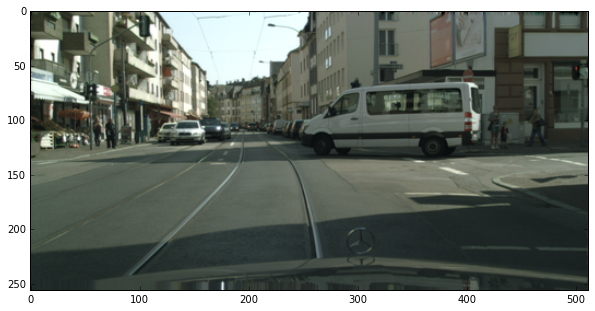

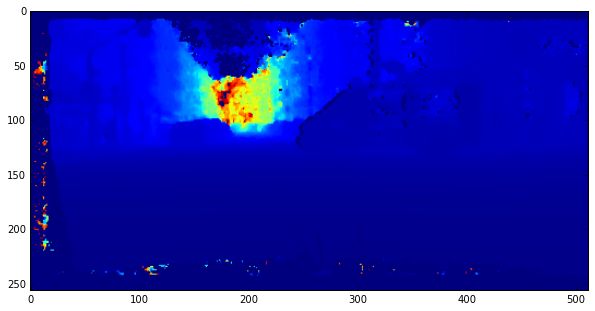

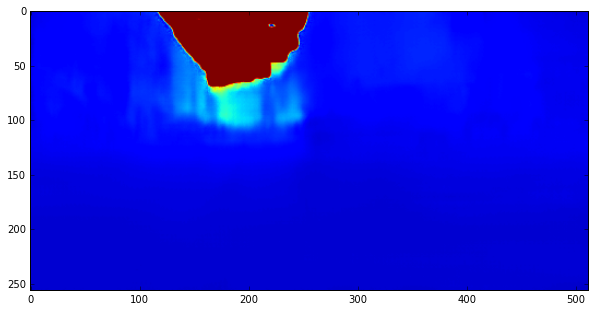

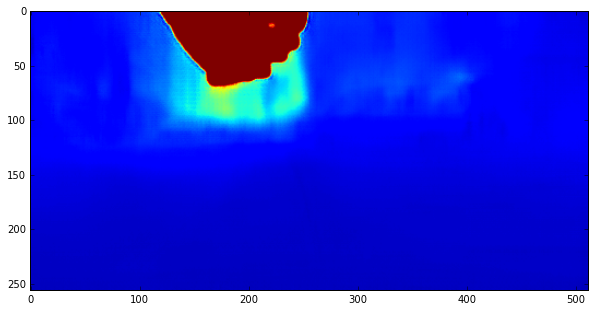

In [111]:
i = 0 
rmse_log_sum = 0.0
rmse_sum = 0.0
sqr_relative_sum = 0.0
abs_relative_sum = 0.0

rmse_log_sum_2 = 0.0
rmse_sum_2 = 0.0
sqr_relative_sum_2 = 0.0
abs_relative_sum_2 = 0.0

rmse_log_mod_sum = 0.0
rmse_mod_sum = 0.0
sqr_relative_mod_sum = 0.0
abs_relative_mod_sum = 0.0

rmse_log_mod_sum_2 = 0.0
rmse_mod_sum_2 = 0.0
sqr_relative_mod_sum_2 = 0.0
abs_relative_mod_sum_2 = 0.0

for filename in r_filenames_img:
    img = Image.open(filename).convert('RGB')
    image = img_transform(img).unsqueeze(0) # torch tensor 1x3xhxw
    
    depth = cv2.imread(r_filenames_dpt[i], cv2.IMREAD_UNCHANGED)
    depth[depth > 473.57] = 473.57 # numpy array
    depth = depth / 473.57 # [0,1]
    
    fake_depth_00 = netG_C_00(image.cuda())
    fake_depth_00 = fake_depth_00[4]
    fake_depth_00 = (fake_depth_00 + 1.0) / 2.0
    
    fake_depth_01 = netG_C_01(image.cuda())
    fake_depth_01 = fake_depth_01[4]
    fake_depth_01 = (fake_depth_01 + 1.0) / 2.0
    
    ar_fake_depth_00 = fake_depth_00.squeeze(0).squeeze(0).cpu().detach().numpy()
    ar_fake_depth_01 = fake_depth_01.squeeze(0).squeeze(0).cpu().detach().numpy()
    
    if i == 5:
        print('depth', depth.min(), depth.mean(), depth.max())
        print('fake_depth_00', ar_fake_depth_00.min(), ar_fake_depth_00.mean(), ar_fake_depth_00.max())
        print('fake_depth_01', ar_fake_depth_01.min(), ar_fake_depth_01.mean(), ar_fake_depth_01.max())

        plt.figure(figsize=(10,10))
        plt.imshow(np.array(img))
        plt.show()
        plt.figure(figsize=(10,10))
        plt.imshow(depth)
        plt.show()
        plt.figure(figsize=(10,10))
        plt.imshow(ar_fake_depth_00)
        plt.show()
        plt.figure(figsize=(10,10))
        plt.imshow(ar_fake_depth_01)
        plt.show()
    
    i = i + 1

In [251]:
def rmse_log(a_fake, a_real, mask, volume):
    return np.sqrt(np.sum((np.log(a_fake[mask]) - np.log(a_real[mask]))**2) / volume)

def rmse(a_fake, a_real):
    return np.sqrt(np.sum((a_fake - a_real)**2) / float(a_fake.shape[0]*a_fake.shape[1]))

def sqr_relative(a_fake, a_real, mask, volume):
    return np.sum((a_fake[mask] - a_real[mask])**2 / a_real[mask]) / volume

def abs_relative(a_fake, a_real, mask, volume):
    return np.sum(np.abs(a_fake[mask] - a_real[mask]) / a_real[mask]) / volume

def accuracy(a_fake, a_real, mask, volume, th):
    return np.sum(np.maximum(a_fake[mask]/a_real[mask], a_real[mask]/a_fake[mask]) < th) / volume

In [252]:
mask1 = a_fake!=0
mask2 = a_real!=0
mask = mask1 * mask2
volume1 = float(np.sum(mask1))
volume2 = float(np.sum(mask2))
volume = float(np.sum(mask))
th = 1.25**3

rmse_log = np.sqrt(np.sum((np.log(a_fake[mask]) - np.log(a_real[mask]))**2) / volume)

rmse = np.sqrt(np.sum((a_fake - a_real)**2) / float(a_fake.shape[0]*a_fake.shape[1]))
             
sqr_relative = np.sum((a_fake[mask2] - a_real[mask2])**2 / a_real[mask2]) / volume2

abs_relative = np.sum(np.abs(a_fake[mask2] - a_real[mask2]) / a_real[mask2]) / volume2

accuracy = np.sum(np.maximum(a_fake[mask]/a_real[mask], a_real[mask]/a_fake[mask]) < th) / volume

print(rmse_log, rmse, sqr_relative, abs_relative, accuracy)

2.453100764151923 106.02188017108661 986.186197917235 11.561364111844096 0.022392225404698065


In [ ]:
# 2.453100763353194 0.4157720793143139 3.8673968546193693 9.639086217432391 0.022392225404698065